# `CLEMnet` predictions on RL012
---
#### Overview
* Model for typical results figure and whatnot

In [1]:
import clemnet

In [2]:
from pathlib import Path
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm

from skimage import io, exposure, color
from skimage import img_as_ubyte, img_as_float
from skimage.util import invert, crop
from skimage.transform import resize
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Set GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Set colormap
plt.set_cmap('magma')
plt.close();

# Ignore annoying Futurewarning from `gray2rgba`
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set ... AUTOTUNE?
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Organize training data
---

In [6]:
# 20200618_RL012
# --------------
# fps_src = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
fps_src = list(Path('/home/mabels/CLEMnet/data/RL012_adjusted/RL012_blurred_6').glob('*/*_*_*.png'))
fps_tgt = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

zoomlevel = 1
b = 0

# Get DataFrame for training
df_trn = clemnet.get_DataFrame(fps_src, fps_tgt)

# Filter out all but 'zoomlevel' zoom level
df_trn = df_trn.loc[df_trn['zoom'] == zoomlevel]
# Filter out a test section
df_trn = df_trn.loc[df_trn['z'] != 7]

# Filter out outermost rows and columns
# where data is poor or does not exist
df_trn_RL012 = pd.DataFrame()

# Must be done per section
for z, grp in df_trn.groupby('z'):
    df_trn_RL012 = df_trn_RL012.append(grp.loc[(grp['x'] > grp['x'].min()+b) &\
                                               (grp['y'] > grp['y'].min()+b) &\
                                               (grp['x'] < grp['x'].max()-b) &\
                                               (grp['y'] < grp['y'].max()-b)])
print(df_trn_RL012)

                                                 source   z   y   x  zoom  \
12    /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  10  10     1   
14    /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  10  11     1   
16    /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  10  12     1   
18    /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  10  13     1   
20    /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  10  14     1   
...                                                 ...  ..  ..  ..   ...   
7099  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   9   5     1   
7101  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   9   6     1   
7103  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   9   7     1   
7106  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   9   8     1   
7109  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   9   9     1   

                                                 target  
12    /home/rlane

In [7]:
# Combine and shuffle DataFrame
df_trn = pd.concat([df_trn_RL012])
df_trn = df_trn.sample(frac=1, random_state=1337).reset_index(drop=True)

# Set source and target filepaths
fps_src = df_trn['source'].values
fps_tgt = df_trn['target'].values

# Preview
out = f"""\
Number of training images... {len(df_trn)}
--------""";print(out)
df_trn.sample(10)

Number of training images... 887
--------


source   z   y   x  zoom  \
602  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3   9  12     1   
381  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  16  10     1   
225  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   8   5     1   
439  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   4  17  12     1   
448  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  13  16     1   
289  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  16   8     1   
152  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   9  17  10     1   
233  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3   9  10     1   
282  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...  10   6   8     1   
578  /home/mabels/CLEMnet/data/RL012_adjusted/RL012...   3  15  14     1   

                                                target  
602  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
381  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
225  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
439  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
448  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
289  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
152  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
233  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
282  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
578  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...

### Create training and validation datasets
First test with very limited dataset size

In [8]:
# Choose validation size
n_validation = int(0.2 * len(df_trn))

# Split into training and validation sets
fps_trn_src = fps_src[:-n_validation]
fps_trn_tgt = fps_tgt[:-n_validation]
fps_val_src = fps_src[-n_validation:]
fps_val_tgt = fps_tgt[-n_validation:]

In [9]:
# Set training parameters
repeat = True
n_repetitions = 4
shape_src = [1024, 1024]
shape_tgt = [256, 256]
augment = True
AUGMENTATIONS = {
    'flip': 1,
    'rotate': 1,
    'crop': 0.,
    'elastic': 0.3,
    'invert': 0.,
    'contrast': 0.3,
    'brightness': 0.3,
    'noise': 0.,
}
pad = False
padding = tf.constant([[16, 16],
                       [16, 16],
                       [ 0,  0]])
batch_size = 16
n_cores = 4

# Create datasets
ds_trn = clemnet.create_dataset(fps_trn_src, fps_trn_tgt, shuffle=False, buffer_size=None,
                                repeat=repeat, n_repetitions=n_repetitions, shape_src=shape_src,
                                shape_tgt=shape_tgt, augment=augment, augmentations=AUGMENTATIONS,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)
ds_val = clemnet.create_dataset(fps_val_src, fps_val_tgt, shuffle=False, buffer_size=None,
                                repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)

# Get first batch for shape info
batch_EM, batch_FM = next(iter(ds_trn))

print(f"""\
Training dataset size..... {tf.data.experimental.cardinality(ds_trn).numpy()}
Validation dataset size... {tf.data.experimental.cardinality(ds_val).numpy()}
EM image shape............ {batch_EM.shape}
FM image shape............ {batch_FM.shape}""")

2022-01-09 16:17:33.668389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-09 16:17:35.656789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-01-09 16:17:35.657122: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-09 16:17:35.659356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-09 16:17:35.660964: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-09 16:17:35.661338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.

Training dataset size..... 178
Validation dataset size... 12
EM image shape............ (16, 1024, 1024, 1)
FM image shape............ (16, 256, 256, 1)


### Preview dataset

  0%|          | 0/16 [00:00<?, ?it/s]

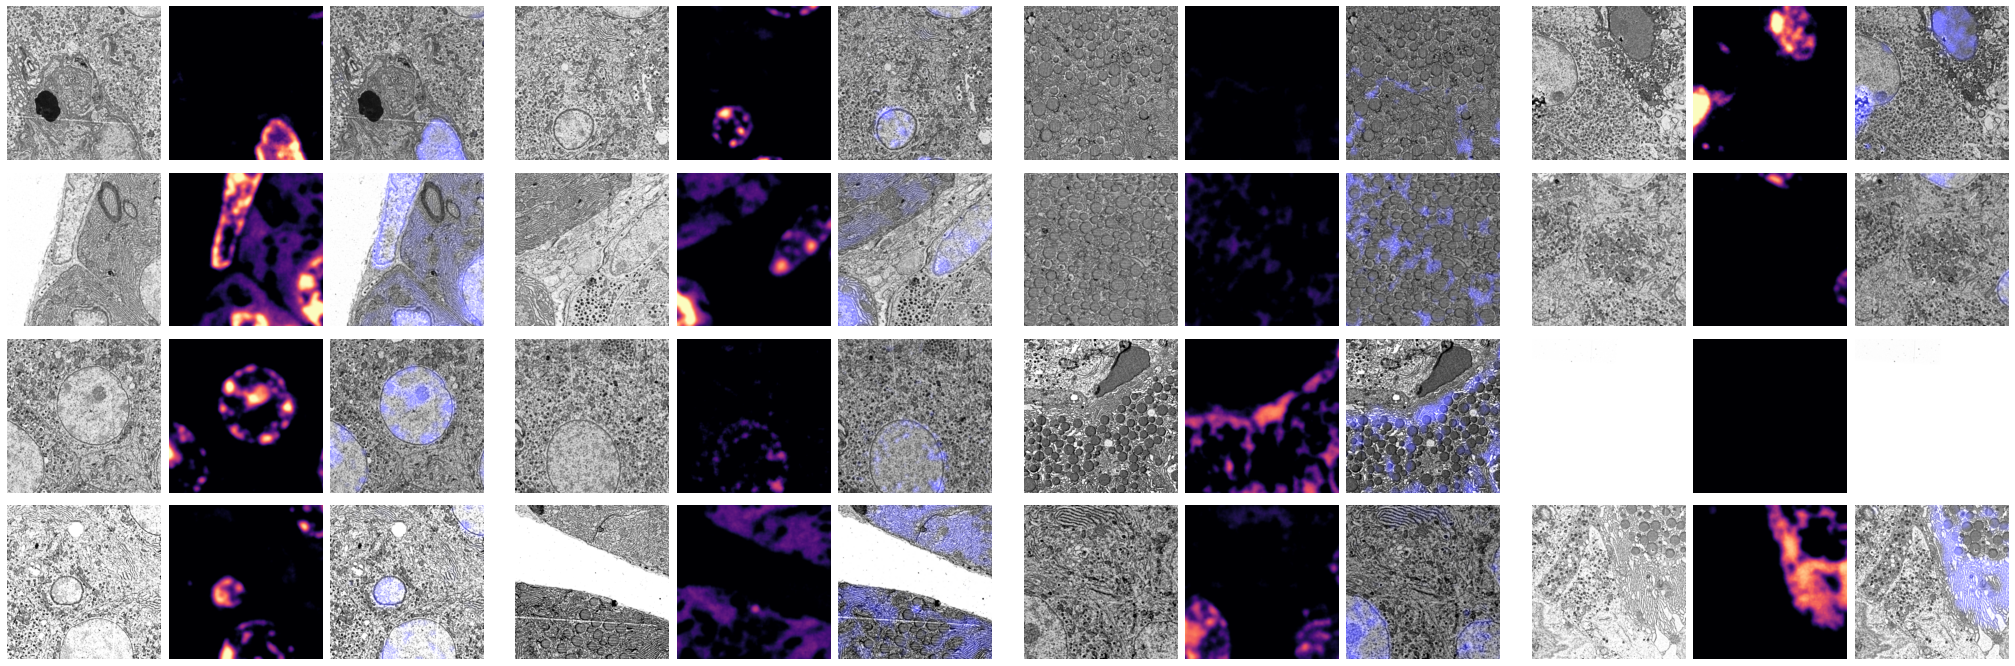

In [10]:
# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*9, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

# Loop through a batch size worth of images
batch_EM, batch_FM = next(iter(ds_trn))
for i in tqdm(range(batch_size)):

    # Fetch images from batch
    img_EM = batch_EM[i,:,:,0].numpy().astype(np.float32)
    img_FM = batch_FM[i,:,:,0].numpy().astype(np.float32)
    # Upsample to fit EM
    img_FM = resize(img_FM, img_EM.shape)

    # Create CLEM image
    img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
    img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
    img_CLEM = exposure.rescale_intensity(img_EM_+img_FM_, in_range=(0, 1))

    # Set up mini gridspec
    gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, wspace=0,
                                           subplot_spec=gs[i])
    ax1 = fig.add_subplot(gss[0])
    ax2 = fig.add_subplot(gss[1])
    ax3 = fig.add_subplot(gss[2])

    # Plot images
    ax1.imshow(img_EM, cmap='Greys', vmin=0, vmax=1)
    ax2.imshow(img_FM, cmap='magma', vmin=0, vmax=1)
    ax3.imshow(img_CLEM)

    # Aesthetics
    [ax.axis('off') for ax in [ax1, ax2, ax3]]

## Training
---

In [11]:
%load_ext tensorboard

### Create model
Need better resolution for insulin prediction

In [12]:
def get_model(input_shape=(1024, 1024), crop=False, crop_width=None):
    """U-net-like convolutional neural network
    Parameters
    ----------
    input_shape : tuple
        Shape of input image data
    crop : bool
        Whether to include a cropping layer
    crop_width : int
        Number of pixels to crop from each border

    Returns
    -------
    model : `keras.Model`
        The model (duh)

    References
    ----------
    [1] U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    [2] Adapted from
        https://github.com/zhixuhao/unet/blob/master/model.py
    """
    # Create input layer
    input_shape = (*input_shape, 1) if len(input_shape) < 3 else input_shape
    inputs = layers.Input(shape=input_shape)

    # Set up keyword arguments for convolutional layers
    kwargs = {
        'activation': 'relu',
        'padding': 'same',
        'kernel_initializer': 'he_normal'
    }

    # Downsampling arm
    # ----------------
    # Block 1
    conv1 = layers.Conv2D(32, 3, **kwargs)(inputs)
    pool1 = layers.MaxPooling2D(2)(conv1)
    # Block 2
    conv2 = layers.Conv2D(64, 3, **kwargs)(pool1)
    pool2 = layers.MaxPooling2D(2)(conv2)
    # Block 3
    conv3 = layers.Conv2D(128, 3, **kwargs)(pool2)
    pool3 = layers.MaxPooling2D(2)(conv3)
    # Block 4
    conv4 = layers.Conv2D(256, 3, **kwargs)(pool3)
    pool4 = layers.MaxPooling2D(2)(conv4)
    # Block 5
    conv5 = layers.Conv2D(512, 3, **kwargs)(pool4)
    pool5 = layers.MaxPooling2D(2)(conv5)
    # Block 6
    conv6 = layers.Conv2D(1024, 3, **kwargs)(pool5)
    pool6 = layers.MaxPooling2D(2)(conv6)

    # Upsampling arm
    # --------------
    # Block 7
    conv7 = layers.Conv2D(1024, 3, **kwargs)(pool6)
    uppp7 = layers.UpSampling2D(2)(conv7)
    # Block 8
    merg8 = layers.concatenate([conv6, uppp7], axis=3)
    conv8 = layers.Conv2D(1024, 3, **kwargs)(merg8)
    uppp8 = layers.UpSampling2D(2)(conv8)
    # Block 9
    merg9 = layers.concatenate([conv5, uppp8], axis=3)
    conv9 = layers.Conv2D(512, 3, **kwargs)(merg9)
    uppp9 = layers.UpSampling2D(2)(conv9)
    # Block 10
    merg10 = layers.concatenate([conv4, uppp9], axis=3)
    conv10 = layers.Conv2D(256, 3, **kwargs)(merg10)
    conv10 = layers.Conv2D(2, 3, **kwargs)(conv10)

    # Additional upsampling
    uppp11 = layers.UpSampling2D(2)(conv10)

    # Output layer
    conv11 = layers.Conv2D(1, 1, activation='sigmoid')(uppp11)
    model = keras.Model(inputs=inputs, outputs=conv11)
    return model

In [13]:
# Get input shape for model
input_shape = batch_EM.shape[1:-1]

# Get model
crop = pad
crop_width = 16
model = get_model(input_shape=input_shape,
                  crop=crop, crop_width=crop_width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Train

In [14]:
# Check if batch size is appropriate
batch_size_max = clemnet.get_max_batch_size(12, model)
print(f"""\
Current batch size... {batch_size}
Max batch size....... {int(np.floor(batch_size_max))}
Good to go..........? {batch_size <= batch_size_max}""")

Current batch size... 16
Max batch size....... 18
Good to go..........? True


### Compile model

In [15]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[clemnet.PCC_tf, clemnet.ICQ_tf])

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Model
model_name = 'RL012_1024x1024_hoechst_zoomlevel_'+ str(zoomlevel) +'_gaussian_blur_6'

# Set callbacks
fp_weights = Path(f"./weights/{model_name}_{timestamp}.h5")
fp_logs = Path(f"./logs/{model_name}_{timestamp}")
fp_weights.parent.mkdir(parents=True, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(fp_weights.as_posix(),
                                    save_best_only=True,
                                    save_weights_only=True),
    keras.callbacks.TensorBoard(log_dir=fp_logs.as_posix()),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=15,
                                  verbose=1)
]

out = f"""\
Saving model to... {fp_weights}
Saving logs to.... {fp_logs}"""
print(out)

Saving model to... weights/RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_6_20220109_161845.h5
Saving logs to.... logs/RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_6_20220109_161845


2022-01-09 16:18:45.797481: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-01-09 16:18:45.797526: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 1 GPUs
2022-01-09 16:18:45.799191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcupti.so.10.1
2022-01-09 16:18:46.339023: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1479] CUPTI activity buffer flushed


In [ ]:
# Train
epochs = 300
n_workers = 4  # AUTOTUNE
history = model.fit(ds_trn,
                    epochs=epochs,
                    validation_data=ds_val,
                    callbacks=callbacks,
                    verbose=1,
                    workers=n_workers,
                    use_multiprocessing=True)

Epoch 1/300


2022-01-09 16:18:51.341180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-09 16:18:52.852580: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-09 16:18:58.259591: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-09 16:18:59.078934: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/178 [..............................] - ETA: 0s - loss: 0.6870 - PCC_tf: -0.0303 - ICQ_tf: -0.4812

2022-01-09 16:19:01.546109: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


  2/178 [..............................] - ETA: 1:48 - loss: 0.5795 - PCC_tf: -0.0279 - ICQ_tf: -0.2059

2022-01-09 16:19:02.347058: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1479] CUPTI activity buffer flushed
2022-01-09 16:19:02.353641: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:216]  GpuTracer has collected 405 callback api events and 405 activity events.
2022-01-09 16:19:02.752191: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_6_20220109_161845/train/plugins/profile/2022_01_09_16_19_02
2022-01-09 16:19:02.765058: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_6_20220109_161845/train/plugins/profile/2022_01_09_16_19_02/hpc29.trace.json.gz
2022-01-09 16:19:02.769763: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.092 ms

2022-01-09 16:19:02.782492: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating direct

 24/178 [===>..........................] - ETA: 2:45 - loss: 0.3133 - PCC_tf: 0.0180 - ICQ_tf: 0.2385

### Plot training history

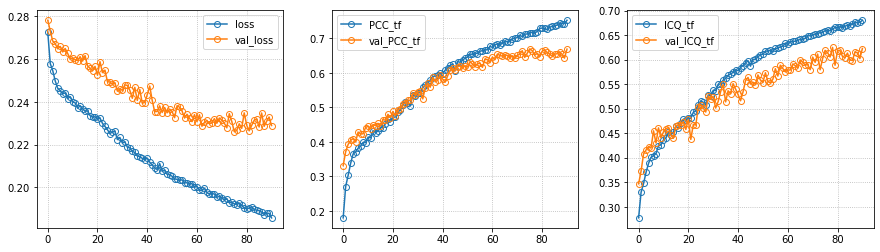

In [15]:
# Collect as DataFrame
df = pd.DataFrame(history.history)
cols = np.stack(df.columns.values.reshape(2, -1), axis=1)

# Plot training data
ncols = len(cols)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4))
for i in range(ncols):
    df.plot(y=cols[i], marker='o', mfc='none', ax=axes[i])
[ax.grid(ls=':') for ax in axes];

In [16]:
# # Filter log data
# log_dir = Path('./logs')
# df = clemnet.parse_tensorboard_logs(log_dir)
# source = df.loc[df['run'] == 'TC002_en_RL012_20210526_184015']

# # Create figure
# nrows = 1
# ncols = len(source['tag'].unique())
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False,
#                          figsize=(7*ncols, 4*nrows))

# # Loop through groups of data
# for i, (tag, grp1) in enumerate(source.groupby('tag')):
#     for (dataset, run), subgrp in grp1.groupby(['dataset', 'run']):
#         subgrp.plot(x='step', y='value', marker='o', mfc='none', ms=10,
#                     label=f'{dataset}', ax=axes[0, i])
#     # Aesthetics
#     axes[0, i].set_title(f"{tag}")
#     axes[0, i].grid(ls=':')
#     axes[0, i].legend(loc='upper right')

## Testing
---

### Load weights

In [17]:
fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel_0_20211214_083058.h5')

model.load_weights(fp_weights.as_posix())

### Create test dataset

In [18]:
# Get training data filepaths
data_dir = Path('/home/rlane/FMML_DATA/20200618_RL012/2us/')
fps_src = list(data_dir.glob('lil_EM*/*/*_*_*.png'))
fps_tgt = list(data_dir.glob('hoechst*/*/*_*_*.png'))

# Get DataFrame for training
df_tst = clemnet.get_DataFrame(fps_src, fps_tgt)

# Filter out all but 0th zoom level
df_tst = df_tst.loc[df_tst['zoom'] == 0]
# Filter out a section for testing
df_tst = df_tst.loc[df_tst['z'] == 7]

# Set source and target filepaths
fps_tst_src = df_tst['source'].values
fps_tst_tgt = df_tst['target'].values
df_tst

source  z   y   x  zoom  \
6243  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7  10  10     0   
6245  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7  10  11     0   
6247  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7  10  12     0   
6249  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7  10  13     0   
6251  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7  10  14     0   
...                                                 ... ..  ..  ..   ...   
7449  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7   9  33     0   
7450  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7   9  34     0   
7451  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7   9  35     0   
7452  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7   9  36     0   
7464  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  7   9   9     0   

                                                 target  
6243  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
6245  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
6247  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
6249  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
6251  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
...                                                 ...  
7449  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
7450  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
7451  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
7452  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
7464  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  

[896 rows x 6 columns]

In [19]:
# Create test dataset
ds_tst = clemnet.create_dataset(fps_tst_src, fps_tst_tgt, shuffle=False, buffer_size=None,
                                repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)

### Make predictions

In [20]:
# Loop through a batch size worth of images
batch_EM, batch_FM = next(iter(ds_tst))

# Make predictions
predictions = model.predict(batch_EM,
                            verbose=1)

1/1 [==============================] - 0s 1ms/step


### Preview predictions

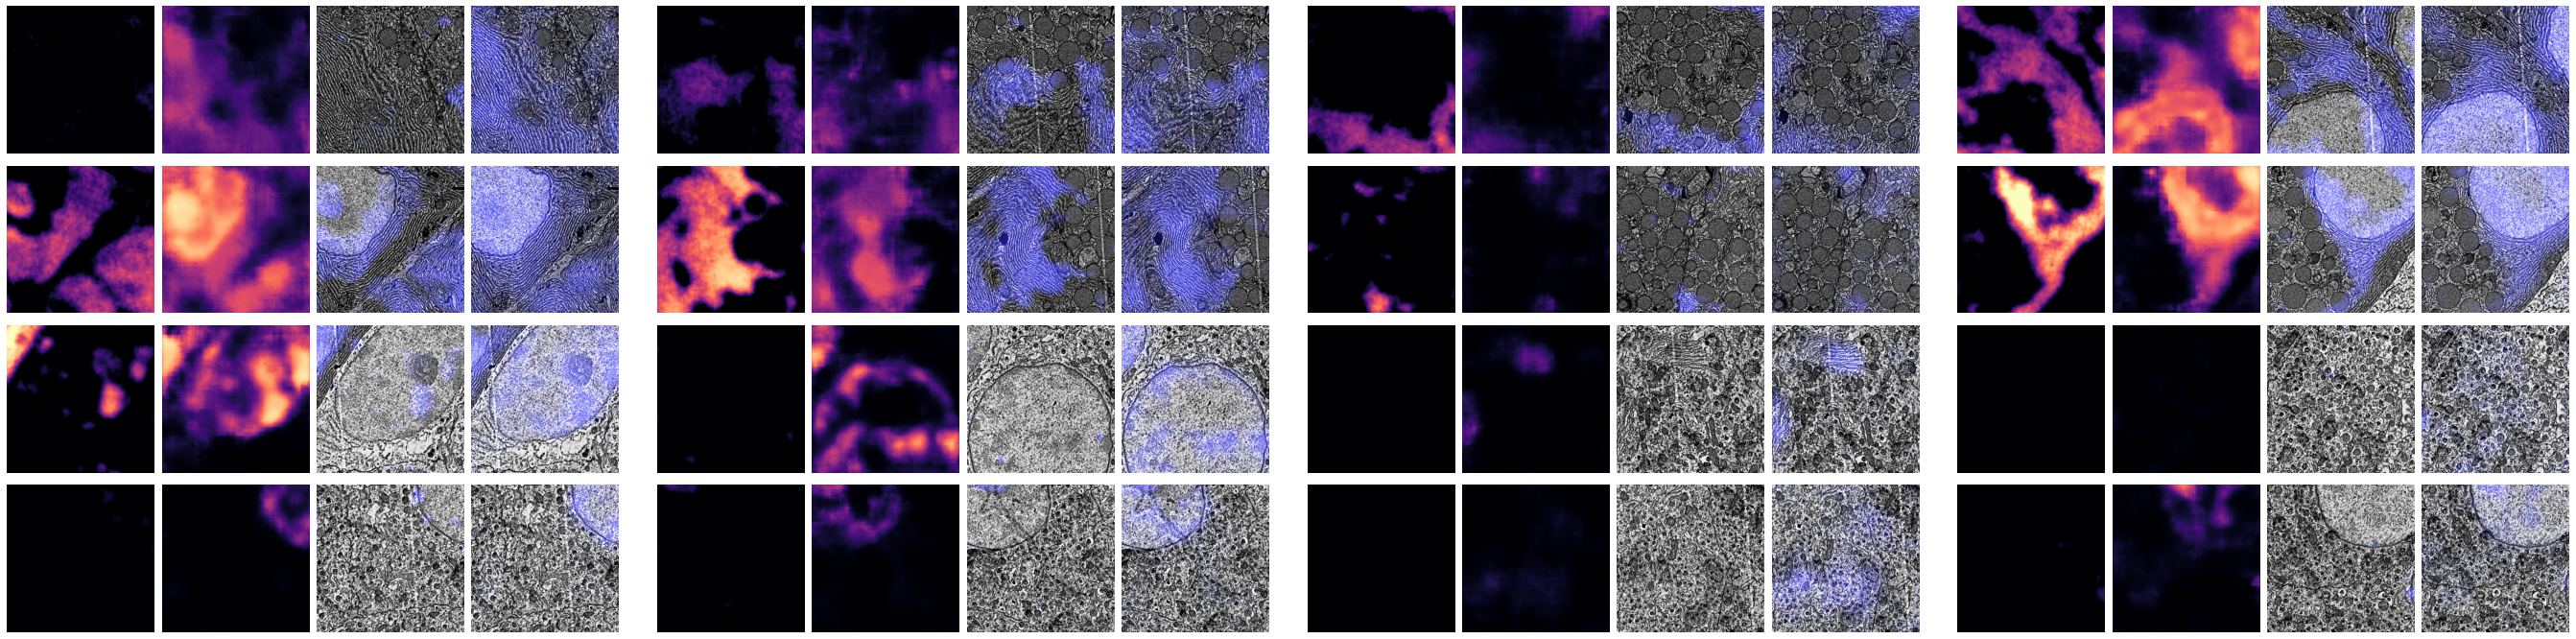

In [21]:
# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*12, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

for i in range(batch_size):

    # Fetch images from batch n
    img_EM = batch_EM[i, :, :, 0].numpy().astype(np.float32)  # (256, 256)
    img_FM = batch_FM[i, :, :, 0].numpy().astype(np.float32)  # (256, 256)
    img_PR = predictions[i, :, :, 0].astype(np.float32)       # (256, 256)

    # Upsample to fit EM
    img_FM = resize(img_FM, img_EM.shape)
    img_PR = resize(img_PR, img_EM.shape)

    # Create CLEM images
    img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
    img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
    img_PR_ = clemnet.colorize(img_PR, clemnet.T_HOECHST)
    img_CLEM = exposure.rescale_intensity(img_EM_+img_FM_, in_range=(0, 1))
    img_PREM = exposure.rescale_intensity(img_EM_+img_PR_, in_range=(0, 1))

    # Set up mini gridspec
    gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, wspace=0,
                                           subplot_spec=gs[i])
    ax1 = fig.add_subplot(gss[0])
    ax2 = fig.add_subplot(gss[1])
    ax3 = fig.add_subplot(gss[2])
    ax4 = fig.add_subplot(gss[3])

    # Plot images
    ax1.imshow(img_FM, cmap='magma', vmin=0, vmax=1)
    ax2.imshow(img_PR, cmap='magma', vmin=0, vmax=1)
    ax3.imshow(img_CLEM)
    ax4.imshow(img_PREM)

    # Aesthetics
    [ax.axis('off') for ax in [ax1, ax2, ax3, ax4]]

### Full section prediction

  0%|          | 0/25 [00:00<?, ?it/s]

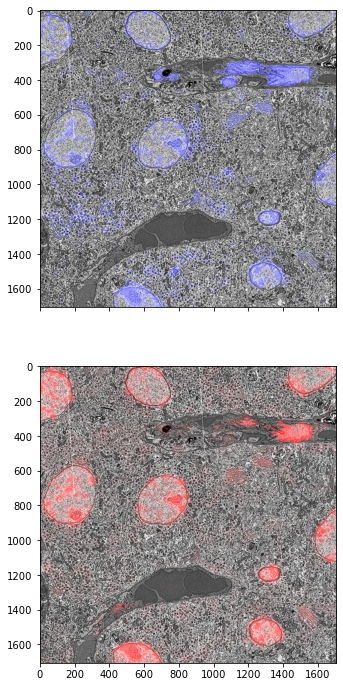

In [22]:
# Make figure
%matplotlib inline
ncols = df_tst['z'].unique().size
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 12),
                         sharex=True, sharey=True, squeeze=False)
axmap = {k:v for k,v in zip(df_tst['z'].unique(), axes.T)}

df_tst_ = df_tst.loc[(df_tst['x'].isin(np.arange(20, 25))) &\
                     (df_tst['y'].isin(np.arange(20, 25)))]
for z, df_sec in df_tst_.groupby('z'):

    # Create dataset for section
    fps_src = df_sec['source'][-30:]
    fps_tgt = df_sec['target'][-30:]
    ds_section = clemnet.create_dataset(fps_src, fps_tgt, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()

    # Create empty arrays for full section images
    batch_EM, batch_FM = next(iter(ds_section))
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])
    section_EM = np.empty(shape)
    section_FM = np.empty(shape)
    section_PR = np.empty(shape)

    # Loop through individual EM and FM tiles
    for (i, row), (batch_EM, batch_FM) in tqdm(zip(df_sec.iterrows(), ds_section),
                                               total=len_ds):
        # Make prediction
        pred = model.predict(batch_EM, verbose=0)

        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        # Populate section images
        crop_width = ((16, 16), (16, 16))
#         section_EM[y1:y2, x1:x2] = crop(batch_EM[0,:,:,0],
#                                         crop_width=crop_width, copy=True)
#         section_FM[y1:y2, x1:x2] = crop(resize(batch_FM[0,:,:,0].numpy().astype(np.float32), batch_EM.shape[1:3]),
#                                         crop_width=crop_width, copy=True)
#         section_PR[y1:y2, x1:x2] = crop(resize(pred[0,:,:,0], batch_EM.shape[1:3]),
#                                         crop_width=crop_width, copy=True)

        section_EM[y1:y2, x1:x2] = batch_EM[0,:,:,0]
        section_FM[y1:y2, x1:x2] = resize(batch_FM[0,:,:,0].numpy().astype(np.float32), batch_EM.shape[1:3])
        section_PR[y1:y2, x1:x2] = resize(pred[0,:,:,0], batch_EM.shape[1:3])

    # Colorize and overlay section images
    section_FM_ = clemnet.colorize(section_FM/section_FM.max(), T=clemnet.T_HOECHST)
    section_PR_ = clemnet.colorize(section_PR/section_PR.max(), T=clemnet.T_RED)
    section_EM_ = color.gray2rgba(invert(section_EM), alpha=True)
    section_CLEM = exposure.rescale_intensity(section_EM_ + section_FM_, in_range=(0, 1))
    section_PRED = exposure.rescale_intensity(section_EM_ + section_PR_, in_range=(0, 1))
    # Plot
    output_shape = [d//3 for d in section_CLEM.shape[:2]]
    axmap[z][0].imshow(resize(section_CLEM, output_shape))
    axmap[z][1].imshow(resize(section_PRED, output_shape))
# #     # Save
# #     fp = Path(f'RL010_S{z:03d}_CLEM.png')
# #     io.imsave(fp.as_posix(), section_CLEM)
# #     fp = Path(f'RL010_S{z:03d}_PRED.png')
# #     io.imsave(fp.as_posix(), section_PRED)